# Churn Prediction & Retention Strategy (Logistic Regression)

This notebook develops a churn prediction model using logistic regression.
Beyond prediction, the analysis focuses on translating model outputs into actionable business retention strategies.

In [25]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve, average_precision_score

import matplotlib.pyplot as plt
import joblib

df = pd.read_csv("Downloads/WA_Fn-UseC_-Telco-Customer-Churn_cleaning1.csv")
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,0
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,0
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,1
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,0
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,1


## Modelling Objective

The goal is to:
- Predict customer churn probability
- Identify high-risk customers
- Apply business-driven decision thresholds
- Support targeted retention interventions## Modelling Objective

The goal is to:
- Predict customer churn probability
- Identify high-risk customers
- Apply business-driven decision thresholds
- Support targeted retention interventions

## Logistic Regression Model

Logistic regression was selected due to its interpretability and alignment with business decision-making requirements.

In [26]:
X = df.drop(columns=["Churn"])
y = df["Churn"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(X_train.shape, X_test.shape)

(5634, 20) (1409, 20)


In [27]:
numeric_features = X.select_dtypes(include=["int64", "float64"]).columns.tolist()
categorical_features = X.select_dtypes(include=["object"]).columns.tolist()

numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median"))
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features)
    ]
)

In [28]:
model = Pipeline(steps=[
    ("preprocess", preprocess),
    ("clf", LogisticRegression(max_iter=2000))
])

model.fit(X_train, y_train)

C:\Users\Dell\anaconda\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median'))]),
                                                  ['SeniorCitizen', 'tenure',
                                                   'MonthlyCharges',
                                                   'TotalCharges']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['customerID', 'gender',
                                                   'Partner', 'Dependents',
                                                   'PhoneService',
                                                   'MultipleLines',
                                                   'InternetService',
                                                   'OnlineSecurity',
                                                   'OnlineBackup',
                                                   'DeviceProtection',
                                                   'TechSupport', 'StreamingTV',
                                                   'StreamingMovies',
                                                   'Contract',
                                                   'PaperlessBilling',
                                                   'PaymentMethod'])])),
                ('clf', LogisticRegression(max_iter=2000))])

## Model Evaluation & Business Threshold Selection

Model performance was evaluated using precision, recall, and F1-score.
A probability threshold of 0.65 was selected based on the precision–recall trade-off to ensure operational feasibility.

In [29]:
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))
print("Confusion matrix:\n", confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.85      0.89      0.87      1035
           1       0.66      0.56      0.61       374

    accuracy                           0.81      1409
   macro avg       0.75      0.73      0.74      1409
weighted avg       0.80      0.81      0.80      1409

Confusion matrix:
 [[925 110]
 [163 211]]


Average Precision (PR-AUC): 0.631


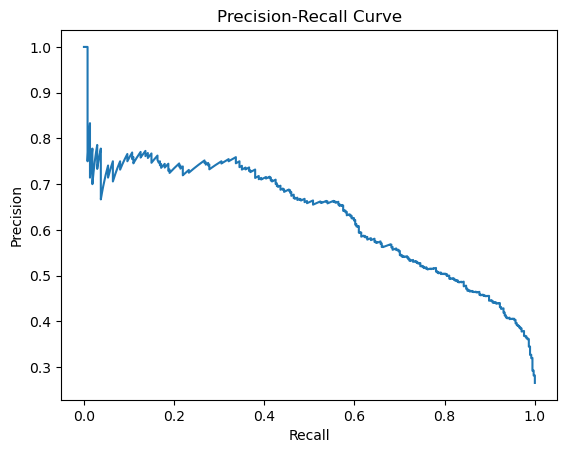

In [30]:
y_proba = model.predict_proba(X_test)[:, 1]
ap = average_precision_score(y_test, y_proba)
print("Average Precision (PR-AUC):", round(ap, 4))

precision, recall, thresholds = precision_recall_curve(y_test, y_proba)

plt.plot(recall, precision)
plt.title("Precision-Recall Curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.show()

In [31]:
pr_df = pd.DataFrame({
    "precision": precision[:-1],
    "recall": recall[:-1],
    "threshold": thresholds
})

pr_df.head()

,precision,recall,threshold
0,0.265436,1.0,0.001594
1,0.265625,1.0,0.001603
2,0.265814,1.0,0.001631
3,0.266003,1.0,0.001646
4,0.266192,1.0,0.001666


In [32]:
pr_df[pr_df["precision"] >= 0.65].head(10)

,precision,recall,threshold
1078,0.651515,0.574866,0.491819
1079,0.653495,0.574866,0.493216
1080,0.652439,0.572193,0.493295
1081,0.654434,0.572193,0.494995
1082,0.653374,0.569519,0.496337
1083,0.652308,0.566845,0.496908
1084,0.654321,0.566845,0.497096
1085,0.656347,0.566845,0.499041
1086,0.655280,0.564171,0.499127
1087,0.657321,0.564171,0.500188


In [33]:
chosen_threshold = 0.65  # example – replace with your selected value

y_pred_business = (y_proba >= chosen_threshold).astype(int)

In [34]:
print(classification_report(y_test, y_pred_business))

              precision    recall  f1-score   support

           0       0.79      0.96      0.87      1035
           1       0.75      0.31      0.44       374

    accuracy                           0.79      1409
   macro avg       0.77      0.64      0.65      1409
weighted avg       0.78      0.79      0.76      1409



In [35]:
targeted_percentage = (y_proba >= chosen_threshold).mean()
print(f"Customers targeted: {targeted_percentage:.2%}")

Customers targeted: 11.00%


### Only 10.93% of customers are flagged for retention action.

### Why this matters for the business
Rather than using a default 0.5 cutoff, a probability threshold was selected based on the precision-recall trade-off.  
This ensures retention actions are targeted at the most at-risk customers while remaining operationally and financially feasible.

In [36]:
df_test = df.loc[X_test.index].copy()

df_test['churn_probability'] = y_proba
df_test['churn_flag'] = y_pred_business

## Customer Risk Segmentation

Customers were segmented into Low, Medium, and High risk groups based on predicted churn probabilities.
This segmentation supports prioritised and cost-effective retention strategies.

In [37]:
def risk_segment(p):
    if p >= 0.65:
        return 'High Risk'
    elif p >= 0.35:
        return 'Medium Risk'
    else:
        return 'Low Risk'

df_test['risk_segment'] = df_test['churn_probability'].apply(risk_segment)

In [38]:
df_test['risk_segment'].value_counts(normalize=True)

risk_segment
Low Risk       0.654365
Medium Risk    0.235628
High Risk      0.110007
Name: proportion, dtype: float64

## High-Risk Customer Profiling

High-risk customers were analysed to identify common characteristics related to tenure, pricing, contract type, and service usage.

In [39]:
high_risk = df_test[df_test['risk_segment'] == 'High Risk']

high_risk[['tenure', 'MonthlyCharges', 'TotalCharges']].describe()

,tenure,MonthlyCharges,TotalCharges
count,155.000000,155.000000,155.000000
mean,7.148387,82.111290,639.881613
std,7.939539,15.100992,776.797849
min,1.000000,24.800000,24.800000
25%,1.500000,74.775000,95.550000
50%,4.000000,80.800000,308.050000
75%,9.000000,94.150000,825.500000
max,38.000000,111.400000,4009.200000


In [40]:
high_risk['Contract'].value_counts(normalize=True)
high_risk['PaymentMethod'].value_counts(normalize=True)
high_risk['InternetService'].value_counts(normalize=True)

InternetService
Fiber optic    0.954839
DSL            0.045161
Name: proportion, dtype: float64

High-risk customers are predominantly early-tenure subscribers with high monthly charges and flexible contract structures. The median tenure of only four months indicates that churn risk materialises early in the customer lifecycle, before sufficient revenue is generated to offset acquisition costs. Additionally, over half of high-risk customers use fiber optic services, suggesting higher expectations and price sensitivity.

In [41]:
retention_actions = pd.DataFrame({
    "Insight": [
        "Low tenure (≤ 6 months)",
        "High monthly charges",
        "Month-to-month contracts",
        "Fiber optic dominance"
    ],
    "Business Action": [
        "Early-life onboarding and welcome offers",
        "Targeted discounts or bill protection plans",
        "Incentivise migration to 12-month contracts",
        "Service quality checks and loyalty bundles"
    ]
})

retention_actions

,Insight,Business Action
0,Low tenure (≤ 6 months),Early-life onboarding and welcome offers
1,High monthly charges,Targeted discounts or bill protection plans
2,Month-to-month contracts,Incentivise migration to 12-month contracts
3,Fiber optic dominance,Service quality checks and loyalty bundles


## Translating Insights into Retention Actions

Analytical insights were converted into concrete retention actions, enabling the model to support prescriptive decision-making.

In [42]:
retention_actions.to_csv("Downloads/retention_strategy_mapping.csv", index=False)

## Revenue Impact & Retention Simulation

The financial impact of churn was quantified by estimating revenue at risk among high-risk customers.
A conservative retention success rate was simulated to estimate potential revenue recovery.

In [43]:
def assign_action(row):
    if row['risk_segment'] == 'High Risk' and row['tenure'] <= 6:
        return "Early-life onboarding + discount"
    elif row['risk_segment'] == 'High Risk':
        return "Contract upgrade incentive"
    else:
        return "No action required"

df_test['recommended_action'] = df_test.apply(assign_action, axis=1)
df_test[['risk_segment', 'tenure', 'recommended_action']].head(10)

,risk_segment,tenure,recommended_action
437,Low Risk,72,No action required
2280,High Risk,8,Contract upgrade incentive
2235,Low Risk,41,No action required
4460,Medium Risk,18,No action required
3761,Low Risk,72,No action required
5748,Medium Risk,21,No action required
3568,Medium Risk,21,No action required
2976,Low Risk,19,No action required
5928,Low Risk,61,No action required
1639,Medium Risk,17,No action required


The churn model outputs were operationalised by assigning automated retention actions at the customer level, transforming predictive analytics into prescriptive decision-making.

## Conclusion

This notebook demonstrates how predictive analytics can be operationalised into business decisions.
By combining interpretable modelling, customer segmentation, and financial analysis, the organisation can proactively reduce churn.

In [44]:
df_test.to_csv("Downloads/churn_scored_customers.csv", index=False)